In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import numpy as np; np.set_printoptions(precision=2); np.random.seed(0)
import torch; torch.set_printoptions(precision=2)
seed = 1

torch.manual_seed(seed)
import torch.nn as nn
import matplotlib.pyplot as plt; plt.rc('font', size=12); plt.rc('font', family='Arial')
import matplotlib 
from matplotlib.font_manager import FontProperties
from mpl_toolkits import mplot3d
import matplotlib.pylab as pl

import seaborn as sns
import time
import sys
import itertools
import random; random.seed(0)
import datetime
import pickle
import copy
import pandas as pd
import scipy
import os

from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import sys
sys.path.append("../two_module_rnn/code")
os.chdir('/home/yl4317/Documents/two_module_rnn/code')
from model import *
from task import *
from functions import *

os.chdir('/home/yl4317/Documents/two_module_rnn/')

print(torch.__version__)
print(sys.version)
                
%matplotlib inline

1.9.0+cu111
3.8.6 (default, Oct 11 2020, 20:34:31) 
[GCC Intel(R) C++ gcc 8.3.1 mode]


In [16]:
# neural_data_all_models = {}
# for model_name in sorted(os.listdir('../two_module_rnn/saved_models/')):
#     if model_name.startswith('success_2022-02-05-14-01-32_'):
#         print('\n'+model_name+'\n')
        
#         # load model
#         model, hp_test, hp_task_test, optim, saved_data = load_model_v2(name=model_name, simple=False, plot=True, toprint=False)

#         # make noiseless
# #         model.rnn.network_noise = 0
# #         hp_test['input_noise_perceptual'] = 0
# #         hp_test['input_noise_rule'] = 0
        
#         # generate some neural data
#         neural_data = generate_neural_data_test(model=model, n_trials_test=100, switch_every_test=10, to_plot=False, 
#                                         hp_test=hp_test, hp_task_test=hp_task_test)
#         neural_data_all_models[model_name] = neural_data

In [12]:
bias_ruletomixerr_allmodels = []
bias_mixerrtorule_allmodels = []

bias_ruleesoma_ruleesoma_allmodels = []
bias_ruleesoma_rulepv_allmodels = []
bias_rulepv_ruleesoma_allmodels = []
bias_rulepv_rulepv_allmodels = []
  
for model_name in sorted(os.listdir('../two_module_rnn/saved_models/')):
    if model_name.startswith('success_2022-02-05-14-01-32_'):
        print('\n'+model_name+'\n')
        
#         # load model
        model, hp_test, hp_task_test, optim, saved_data = load_model_v2(name=model_name, simple=False, plot=False, toprint=False)

        # make noiseless
#         model.rnn.network_noise = 0
#         hp_test['input_noise_perceptual'] = 0
#         hp_test['input_noise_rule'] = 0
        
        # generate some neural data
        neural_data = generate_neural_data_test(model=model, n_trials_test=100, switch_every_test=10, to_plot=False, 
                                        hp_test=hp_test, hp_task_test=hp_task_test)
#         neural_data_all_models[model_name] = neural_data

#         neural_data = neural_data_all_models[model_name]

        test_data = neural_data['test_data']
        rnn_activity = neural_data['rnn_activity']
        current_matrix = neural_data['current_matrix']
        
        # generate trial labels
        trial_labels = label_trials(test_data=test_data)
#         trial_labels_all_models[model_name] = trial_labels
        rule1_trs_stable = trial_labels['rule1_trs_stable']
        rule2_trs_stable = trial_labels['rule2_trs_stable']
        rule1_trs_after_error = trial_labels['rule1_trs_after_error']
        rule2_trs_after_error = trial_labels['rule2_trs_after_error']
        left_trs_stable = trial_labels['left_trs_stable']
        right_trs_stable = trial_labels['right_trs_stable']
        error_trials = trial_labels['error_trials']
        
        # compute cell selectivity
        all_sels = compute_sel_pfc_cxtdm(rnn_activity=rnn_activity, hp=hp_test, hp_task=hp_task_test, rule1_trs_stable=rule1_trs_stable, rule2_trs_stable=rule2_trs_stable,
                                        left_trs_stable=left_trs_stable, right_trs_stable=right_trs_stable, stims=test_data['stims'], error_trials=error_trials)
        rule_sel_used = all_sels['rule_normalized_activity']
        error_sel_used = all_sels['error_normalized']
        
        # define subpopulations within PFC
        subcg_pfc_idx = define_subpop_pfc(model=model, hp_task=hp_task_test, hp=hp_test, rnn_activity=rnn_activity, 
                                          rule_sel=rule_sel_used, err_sel=error_sel_used, rule1_trs_stable=rule1_trs_stable, 
                                          rule2_trs_stable=rule2_trs_stable, rule1_after_error_trs=rule1_trs_after_error,
                                          rule2_after_error_trs=rule2_trs_after_error,
                                          rule_threshold=0.5, err_threshold=0.5)
        for subcg in subcg_pfc_idx.keys():
            model.rnn.cg_idx['subcg_pfc_'+subcg] = subcg_pfc_idx[subcg]
        
        # calculate connectivity bias
        w_rec_eff = model.rnn.effective_weight(w=model.rnn.w_rec, mask=model.rnn.mask, w_fix=model.rnn.w_fix).detach().cpu().numpy()
        
        ## structure from rule -> mixerr
        bias_ruleesoma_mixerr = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_esoma'], subcg_pfc_idx['mix_err_rule2_esoma'])])\
                               +np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_esoma'], subcg_pfc_idx['mix_err_rule1_esoma'])])\
                               -np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_esoma'], subcg_pfc_idx['mix_err_rule1_esoma'])])\
                               -np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_esoma'], subcg_pfc_idx['mix_err_rule2_esoma'])])
        bias_rulepv_mixerr = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pv'], subcg_pfc_idx['mix_err_rule1_esoma'])])\
                             +np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pv'], subcg_pfc_idx['mix_err_rule2_esoma'])])\
                             -np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pv'], subcg_pfc_idx['mix_err_rule2_esoma'])])\
                             -np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pv'], subcg_pfc_idx['mix_err_rule1_esoma'])])
        bias_ruletomixerr = np.mean([bias_ruleesoma_mixerr, -bias_rulepv_mixerr])
        bias_ruletomixerr_allmodels.append(bias_ruletomixerr)
        if False:
            _, _ = plot_conn_subpop(weight=w_rec_eff, cg_idx=subcg_pfc_idx, subcg_to_plot_sender=['rule1_esoma', 'rule2_esoma'], subcg_to_plot_receiver=['mix_err_rule1_esoma', 'mix_err_rule2_esoma'])
            _, _ = plot_conn_subpop(weight=w_rec_eff, cg_idx=subcg_pfc_idx, subcg_to_plot_sender=['rule1_pv', 'rule2_pv'], subcg_to_plot_receiver=['mix_err_rule1_esoma', 'mix_err_rule2_esoma'])
        
        ## structure from mixerr -> rule
        bias_mixerr_ruleesoma = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_err_rule1_esoma'], subcg_pfc_idx['rule1_esoma'])])\
                               +np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_err_rule2_esoma'], subcg_pfc_idx['rule2_esoma'])])\
                               -np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_err_rule1_esoma'], subcg_pfc_idx['rule2_esoma'])])\
                               -np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_err_rule2_esoma'], subcg_pfc_idx['rule1_esoma'])])
        bias_mixerr_pv = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_err_rule1_esoma'], subcg_pfc_idx['rule1_pv'])])\
                               +np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_err_rule2_esoma'], subcg_pfc_idx['rule2_pv'])])\
                               -np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_err_rule1_esoma'], subcg_pfc_idx['rule2_pv'])])\
                               -np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_err_rule2_esoma'], subcg_pfc_idx['rule1_pv'])])
        bias_mixerrtorule = np.mean([bias_mixerr_ruleesoma, bias_mixerr_pv])
        bias_mixerrtorule_allmodels.append(bias_mixerrtorule)
        if False:
            _, _ = plot_conn_subpop(weight=w_rec_eff, cg_idx=subcg_pfc_idx, subcg_to_plot_sender=['mix_err_rule1_esoma', 'mix_err_rule2_esoma'], subcg_to_plot_receiver=['rule1_esoma', 'rule2_esoma'])
            _, _ = plot_conn_subpop(weight=w_rec_eff, cg_idx=subcg_pfc_idx, subcg_to_plot_sender=['mix_err_rule1_esoma', 'mix_err_rule2_esoma'], subcg_to_plot_receiver=['rule1_pv', 'rule2_pv'])
        
        
        
        # bias within rule network
        rule_subregion = ['rule1_esoma', 'rule2_esoma', 'rule1_pv', 'rule2_pv']
        ## from rule_esoma to rule_esoma
        bias_ruleesoma_ruleesoma = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_esoma'], subcg_pfc_idx['rule1_esoma'])])\
                                  +np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_esoma'], subcg_pfc_idx['rule2_esoma'])])\
                                  -np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_esoma'], subcg_pfc_idx['rule2_esoma'])])\
                                  -np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_esoma'], subcg_pfc_idx['rule1_esoma'])])
        bias_ruleesoma_ruleesoma_allmodels.append(bias_ruleesoma_ruleesoma)
        
        ## from rule_esoma to rule_pv
        bias_ruleesoma_rulepv = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_esoma'], subcg_pfc_idx['rule1_pv'])])\
                                +np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_esoma'], subcg_pfc_idx['rule2_pv'])])\
                                -np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_esoma'], subcg_pfc_idx['rule2_pv'])])\
                                -np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_esoma'], subcg_pfc_idx['rule1_pv'])])
        bias_ruleesoma_rulepv_allmodels.append(bias_ruleesoma_rulepv)
        ## from rule_pv to rule_esoma
        bias_rulepv_ruleesoma = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pv'], subcg_pfc_idx['rule2_esoma'])])\
                                +np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pv'], subcg_pfc_idx['rule1_esoma'])])\
                                -np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pv'], subcg_pfc_idx['rule1_esoma'])])\
                                -np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pv'], subcg_pfc_idx['rule2_esoma'])])
        bias_rulepv_ruleesoma = -bias_rulepv_ruleesoma    # so that it is positive
        bias_rulepv_ruleesoma_allmodels.append(bias_rulepv_ruleesoma)
        ## from rule_pv to rule_pv
        bias_rulepv_rulepv = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pv'], subcg_pfc_idx['rule2_pv'])])\
                            +np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pv'], subcg_pfc_idx['rule2_pv'])])\
                            -np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pv'], subcg_pfc_idx['rule1_pv'])])\
                            -np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pv'], subcg_pfc_idx['rule2_pv'])])
        bias_rulepv_rulepv = -bias_rulepv_rulepv    # so that it is positive
        bias_rulepv_rulepv_allmodels.append(bias_rulepv_rulepv)
        
        # plot the connectivity
        if False:
            _, _ = plot_conn_subpop(weight=w_rec_eff, cg_idx=subcg_pfc_idx, subcg_to_plot_sender = rule_subregion, subcg_to_plot_receiver=rule_subregion)
        
        
        
        
        
        
    


success_2022-02-05-14-01-32_cxtdm_dendnonlinearold_divisivedendei_gradremovehistory_fulltask_2branches_useReLUforWeff_sronlytopfcpv_init=kaiming_normal_l2h=0_torchseed=1_lr=0.001_optim=Adam_run1

network noise in hp: 0.01
network noise in hp_copy: 0.01
mean test loss=0.1438, mean test perf=0.8800, mean test perf rule=0.8800, max test perf=0.9000, time=2.79s
switch_every_test=10, n_trials_test=100

success_2022-02-05-14-01-32_cxtdm_dendnonlinearold_divisivedendei_gradremovehistory_fulltask_2branches_useReLUforWeff_sronlytopfcpv_init=kaiming_normal_l2h=0_torchseed=1_lr=0.001_optim=Adam_run2

network noise in hp: 0.01
network noise in hp_copy: 0.01
mean test loss=0.1397, mean test perf=0.8800, mean test perf rule=0.8900, max test perf=0.9000, time=2.69s
switch_every_test=10, n_trials_test=100

success_2022-02-05-14-01-32_cxtdm_dendnonlinearold_divisivedendei_gradremovehistory_fulltask_2branches_useReLUforWeff_sronlytopfcpv_init=kaiming_normal_l2h=0_torchseed=1_lr=0.001_optim=Adam_run3

n

KeyboardInterrupt: 

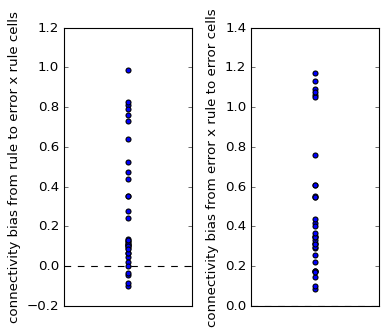

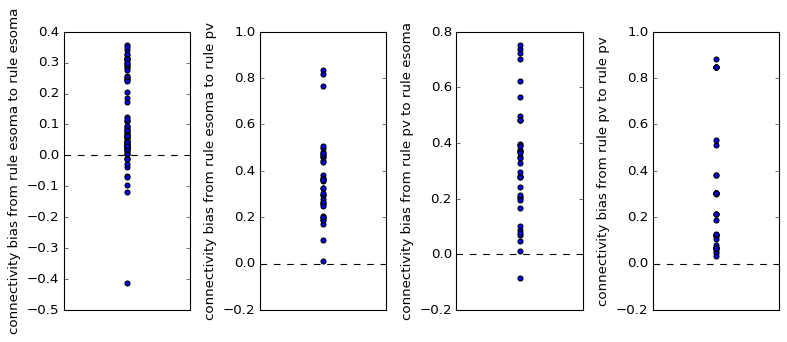

In [8]:
plt.rc('font', size=12)

fig, ax=plt.subplots(1,2,figsize=[5,4])
fig.patch.set_facecolor('white')
for y in bias_ruletomixerr_allmodels:
    ax[0].scatter(x=1, y=y)
    ax[0].set_xticks([])
    ax[0].set_ylabel('connectivity bias from rule to error x rule cells')
for y in bias_mixerrtorule_allmodels:
    ax[1].scatter(x=1, y=y)
    ax[1].set_xticks([])
    ax[1].set_ylabel('connectivity bias from error x rule to error cells')
for i in range(2):
    ax[i].axhline(y=0, ls='--', color='k')
fig.tight_layout()
plt.show()


fig, ax=plt.subplots(1,4,figsize=[10,4])
fig.patch.set_facecolor('white')
for y in bias_ruleesoma_ruleesoma_allmodels:
    ax[0].scatter(x=1, y=y)
    ax[0].set_xticks([])
    ax[0].set_ylabel('connectivity bias from rule esoma to rule esoma')
for y in bias_ruleesoma_rulepv_allmodels:
    ax[1].scatter(x=1, y=y)
    ax[1].set_xticks([])
    ax[1].set_ylabel('connectivity bias from rule esoma to rule pv')
for y in bias_rulepv_ruleesoma_allmodels:
    ax[2].scatter(x=1, y=y)
    ax[2].set_xticks([])
    ax[2].set_ylabel('connectivity bias from rule pv to rule esoma')
for y in bias_rulepv_rulepv_allmodels:
    ax[3].scatter(x=1, y=y)
    ax[3].set_xticks([])
    ax[3].set_ylabel('connectivity bias from rule pv to rule pv')
    
for i in range(4):
    ax[i].axhline(y=0, ls='--', color='k')
fig.tight_layout()
plt.show()




In [ ]:
# Plot the connectivity according to the bias